## Session4. Normalization, Dimension reduction and Batch correction

This session introduces essential steps in preparing single-cell ATAC-seq data for biological interpretation. After initial preprocessing and quality control, it is crucial to correct for batch effects, normalize accessibility profiles, and identify cell populations through clustering.

- Batch Effects: Technical variability from different runs, libraries, or conditions can obscure true biological signals.

- Normalization: scATAC-seq data is inherently sparse and biased by sequencing depth. Proper normalization ensures comparability across cells.

- Clustering: Helps uncover cell states and types based on chromatin accessibility landscapes.

##### Setup
First, ensure that the necessary R packages are installed and loaded.

In [ ]:
# Install required packages if not already installed
if (!requireNamespace("Signac", quietly = TRUE)) {
  install.packages("Signac")
}
if (!requireNamespace("Seurat", quietly = TRUE)) {
  install.packages("Seurat")
}

if (!requireNamespace("ggplot2", quietly = TRUE)) {
  install.packages("ggplot2")
}

if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}

if (!requireNamespace("GenomicRanges", quietly = TRUE)) {
BiocManager::install("GenomicRanges")
}


# Load libraries
library(Signac)
library(Seurat)
library(GenomicRanges)
library(ggplot2)


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following 

##### Load the processed dataset saved from previous session

In [ ]:
data = readRDS('data/PBMC.ATAC.after_qc.rds')

In [ ]:
# Reset fragment data paths
new_path1 <- "/Users/marc/Desktop/CDN/workshop_CDN_2025/data/pbmc_unsorted_10k_atac_fragments.tsv.gz"
new_path2 <- "/Users/marc/Desktop/CDN/workshop_CDN_2025/data/10k_PBMC_Multiome_nextgem_Chromium_Controller_atac_fragments.tsv.gz"
frags <- Fragments(data)  # get list of fragment objects
Fragments(data) <- NULL  # remove fragment information from assay
frags[[1]] <- UpdatePath(frags[[1]], new.path = new_path1)  # update path. Do this for any/all fragment objects in the list
frags[[2]] <- UpdatePath(frags[[2]], new.path = new_path2)  # update path. Do this for any/all fragment objects in the list
Fragments(data) <- frags  # assign update list of fragment objects back to the assay

### Step1. Normalization

Single-cell ATAC-seq data is characterized by its high sparsity and binary accessibility profiles, making traditional normalization and feature selection methods (e.g., those from scRNA-seq) less effective.

This session introduces specialized strategies to prepare chromatin accessibility data for dimensionality reduction and clustering.


- Corrects for sequencing depth differences across cells

- Highlights biologically relevant peaks by emphasizing rarer regions

- Reduces noise and dimensionality before downstream analysis

### Step1-1. Normalization (TF-IDF)

Term Frequency - Inverse Document Frequency (TF-IDF) is adapted from natural language processing and applied to peak-by-cell matrices.


- Two-step normalization

   - Term Frequency (TF): Normalizes each cell by its sequencing depth (total fragments in peaks).
   - Inverse Document Frequency (IDF): Gives higher weight to rare peaks, down-weighting peaks accessible in many cells.

##### Run TF-IDF

In [4]:
data <- RunTFIDF(data)


Performing TF-IDF normalization



### Step1-2. Feature selection

Unlike scRNA-seq, scATAC-seq data has a low dynamic range, making traditional variable feature selection less effective. Instead of identifying highly variable features, we typically:

- Use all peaks

- Restrict to the top n% most frequent peaks (e.g., using min.cutoff = 'q75' for the top 25%)

- Remove rare peaks present in fewer than n cells using the FindTopFeatures() function.


In this workflow, we will use all features for dimensionality reduction. However, using a subset (like the top 25%) produces comparable results with improved computational efficiency.

##### Specify the set of features (peaks) to be used for dimensionality reduction

In [5]:
data <- FindTopFeatures(data, min.cutoff = 'q0')


### Step2. 🔹 Dimensionality Reduction: SVD on TF-IDF Matrix

Next, we perform Singular Value Decomposition (SVD) on the TF-IDF-transformed peak-by-cell matrix, using the features selected in the previous step.

- This step produces a low-dimensional representation of the chromatin accessibility data.

- Conceptually, this is similar to PCA used in scRNA-seq analysis, but tailored to the sparse nature of scATAC-seq data.

- SVD captures major axes of variation in peak accessibility and is used as the basis for downstream clustering and visualization.

##### Run SVD

In [6]:
data <- RunSVD(data)


Running SVD

Scaling cell embeddings



##### Latent Semantic Indexing (LSI)
The combination of TF-IDF transformation followed by SVD is known as Latent Semantic Indexing (LSI).

This approach was first introduced for analyzing scATAC-seq data by Cusanovich et al., 2015, and has since become a widely adopted method for dimensionality reduction in single-cell chromatin accessibility analysis.

##### Interpreting LSI Components
- The first LSI component often reflects technical variation, such as sequencing depth, rather than true biological differences.

- If inspection confirms that this component captures technical artifacts, it is recommended to exclude it from downstream analysis (e.g., clustering or visualization) to avoid misleading results.

##### Assess whether the LSI components capture technical variation, such as sequencing depth

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”


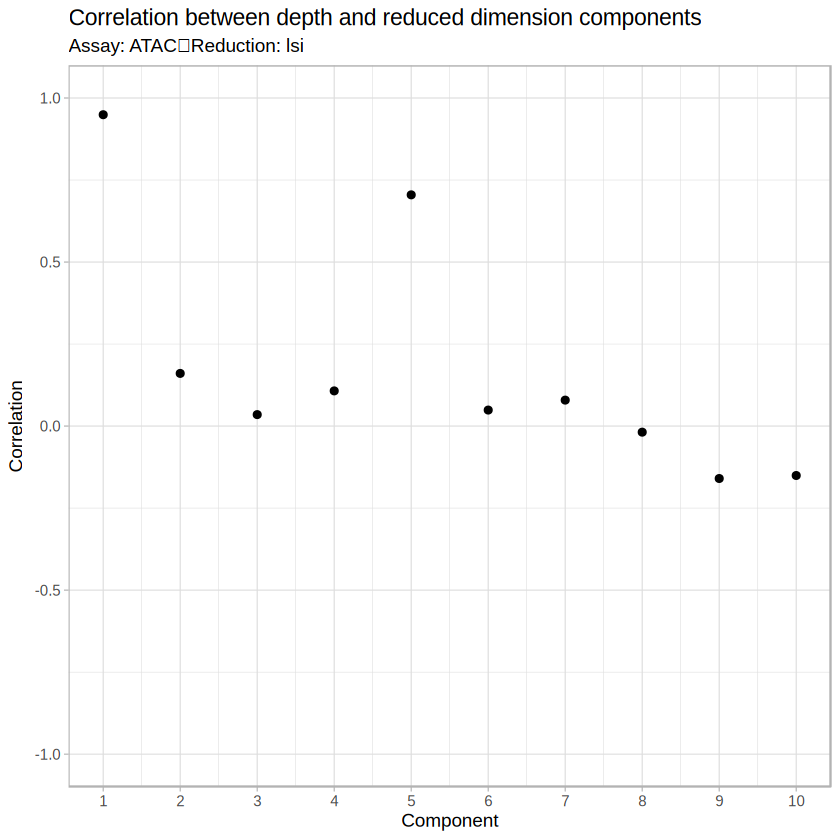

In [7]:
DepthCor(data)

- In this dataset, we observe a strong correlation between the first LSI component and the total number of fragments per cell, indicating that this component primarily reflects sequencing depth rather than biological variation.

- To avoid clustering cells based on technical factors, we will exclude the first LSI component from downstream analyses such as clustering and UMAP.

##### UMAP for visualization
After normalization, and dimensionality reduction, we need a way to visualize high-dimensional data in a form humans can interpret. UMAP (Uniform Manifold Approximation and Projection) is a powerful tool that projects cells into a 2D or 3D space, preserving their structure and relationships.



In [ ]:
    data <- RunUMAP(object = data, reduction = 'lsi', dims = 2:30)


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:47:05 UMAP embedding parameters a = 0.9922 b = 1.112

21:47:05 Read 20296 rows and found 29 numeric columns

21:47:05 Using Annoy for neighbor search, n_neighbors = 30

21:47:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:47:07 Writing NN index file to temp file /tmp/Rtmpbdv5Qr/file5ea5d7aa01e50

21:47:07 Searching Annoy index using 1 thread, search_k = 3000

21:47:13 Annoy recall = 100%

21:47:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)

p1<- DimPlot(object = data,  group.by = 'dataset')

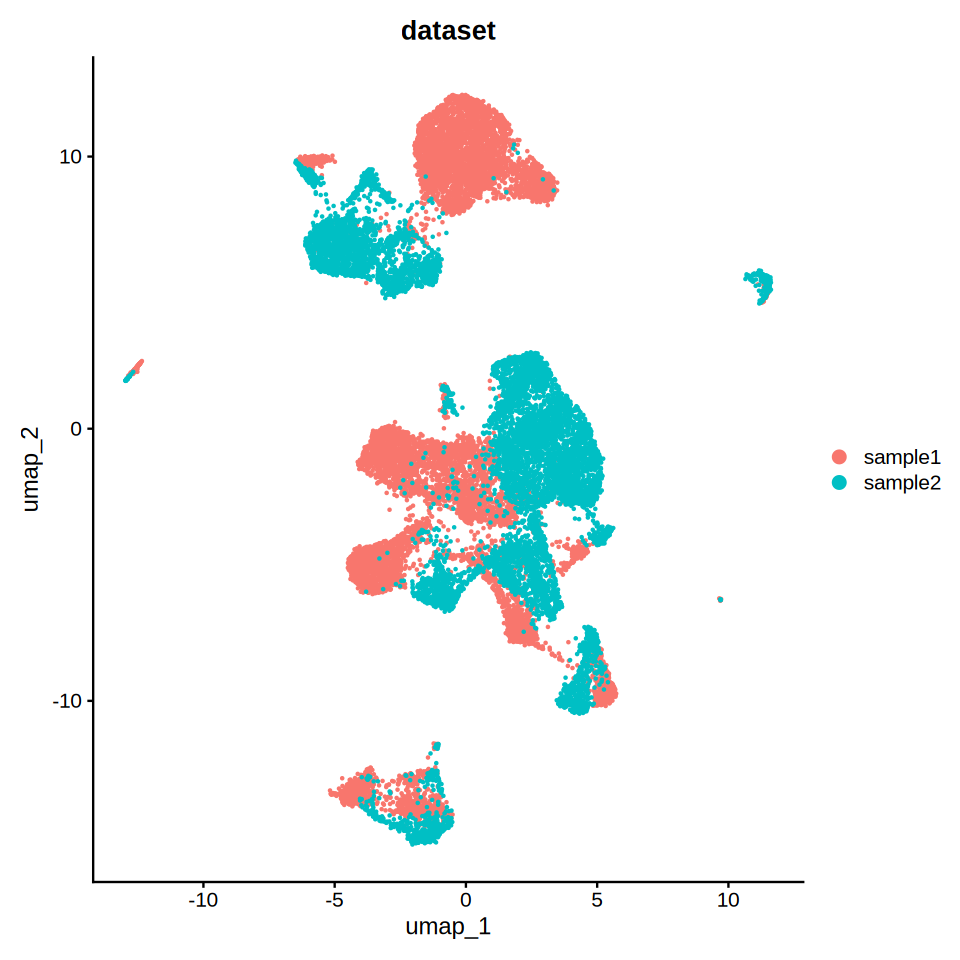

In [10]:
print(p1)

### Step3. Batch Correction

In single-cell ATAC-seq experiments, data are often generated across multiple batches—different sequencing runs, library preps, or sample sources. These can introduce unwanted technical variations that obscure true biological differences. Batch correction aims to align cells across datasets into a shared embedding space, enabling accurate clustering and interpretation.

- Batch correction is essential before clustering when analyzing multi-sample datasets.

#####  Data Integration with Reciprocal LSI
To integrate two scATAC-seq datasets, we must first project them into a shared low-dimensional space to identify integration anchors.
This is accomplished using reciprocal LSI (rLSI) projection, where each dataset is projected into the LSI space of the other.

##### Split the dataset by sample to enable anchor detection for integration

In [11]:
data.sample1 <- subset(
  x = data,
  subset =
    dataset=='sample1'
)
data.sample1

An object of class Seurat 
130381 features across 10812 samples within 1 assay 
Active assay: ATAC (130381 features, 130381 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

In [12]:
data.sample2 <- subset(
  x = data,
  subset =
    dataset=='sample2'
)
data.sample2

An object of class Seurat 
130381 features across 9484 samples within 1 assay 
Active assay: ATAC (130381 features, 130381 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

##### Identify integration anchors between datasets for alignment.

In [ ]:
# find integration anchors
integration.anchors <- FindIntegrationAnchors(
  object.list = list(data.sample1, data.sample2),
  anchor.features = rownames(data),
  reduction = "rlsi",
  dims = 2:30
)

Computing within dataset neighborhoods

Finding all pairwise anchors

Converting layer counts in assay ATAC to empty dgCMatrix

Converting layer counts in assay ATAC to empty dgCMatrix

Warning message:
“No filtering performed if passing to data rather than counts”
Warning message:
“`FilterObjects()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `.FilterObjects()` instead.
ℹ The deprecated feature was likely used in the SeuratObject package.
  Please report the issue at <https://github.com/satijalab/seurat-object/issues>.”
Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 11785 anchors



##### Integrate LSI embeddings across samples using identified anchors (batch correction)

In [14]:
# integrate LSI embeddings
integrated <- IntegrateEmbeddings(
  anchorset = integration.anchors,
  reductions = data[["lsi"]],
  new.reduction.name = "integrated_lsi",
  dims.to.integrate = 1:30
)


Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”


In [15]:
# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "dataset")

21:50:19 UMAP embedding parameters a = 0.9922 b = 1.112

21:50:19 Read 20296 rows and found 29 numeric columns

21:50:19 Using Annoy for neighbor search, n_neighbors = 30

21:50:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:50:20 Writing NN index file to temp file /tmp/Rtmpbdv5Qr/file5ea5d9cab119

21:50:20 Searching Annoy index using 1 thread, search_k = 3000

21:50:26 Annoy recall = 100%

21:50:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:50:28 Initializing from normalized Laplacian + noise (using RSpectra)

21:50:29 Commencing optimization for 200 epochs, with 836724 positive edges

21:50:29 Using rng type: pcg

21:50:38 Optimization finished



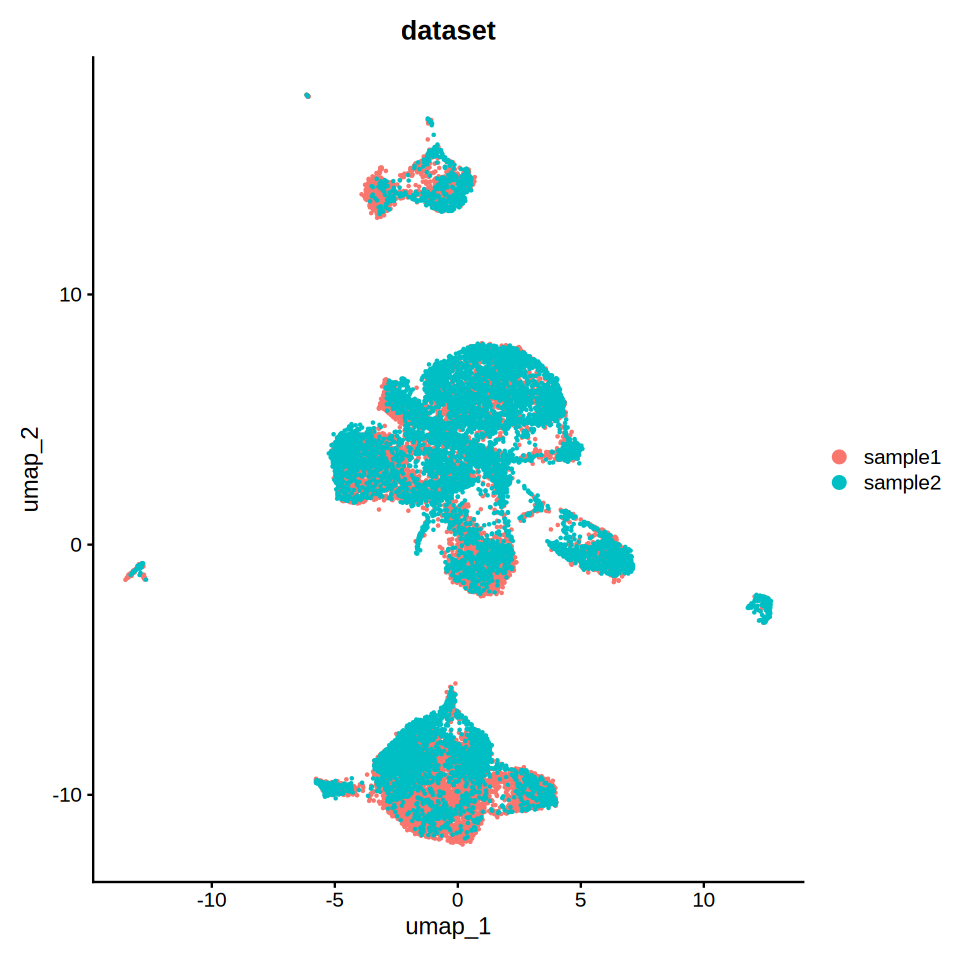

In [16]:
p2

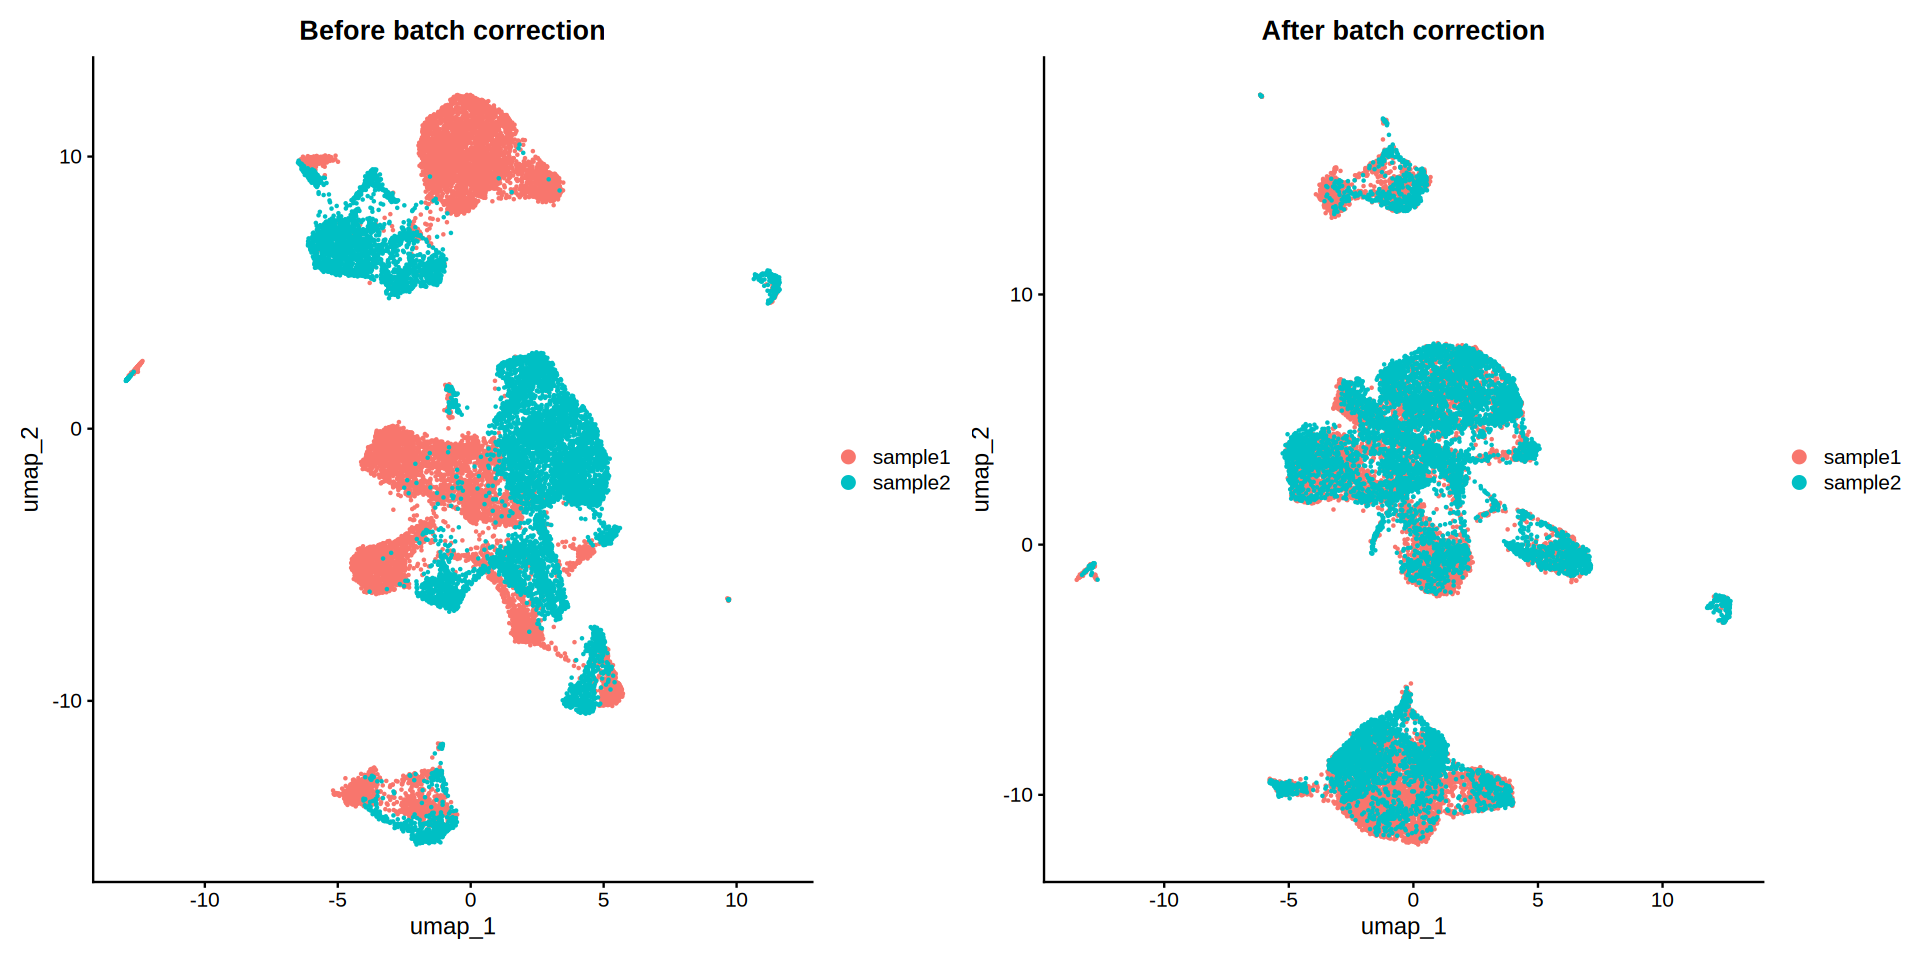

In [17]:
options(repr.plot.width = 16, repr.plot.height = 8)
(p1 + ggtitle("Before batch correction")) | (p2 + ggtitle("After batch correction"))

In [19]:
saveRDS(integrated,'PBMC.ATAC.after_qc.batch_corrected.rds')